# Instructions

## Part 0 - Getting set up with Google Colab

 1. Open [Google colab](https://colab.research.google.com/)
 2. Create a new notebook; see [here](https://www.educative.io/answers/how-to-create-a-notebook-in-google-colab) for instructions
 
## Part 1 - Copying/running code

 1. Copy the code in cell 1 and paste it into the first cell
 2. Run the first cell; if it worked, you should see the message "If you're seeing this, the cell ran properly!  You can proceed to the next step."
 3. Copy the code in cell 2 and paste it into the next cell
 4. Run the second cell; if it worked, you should see a plot that looks like this: 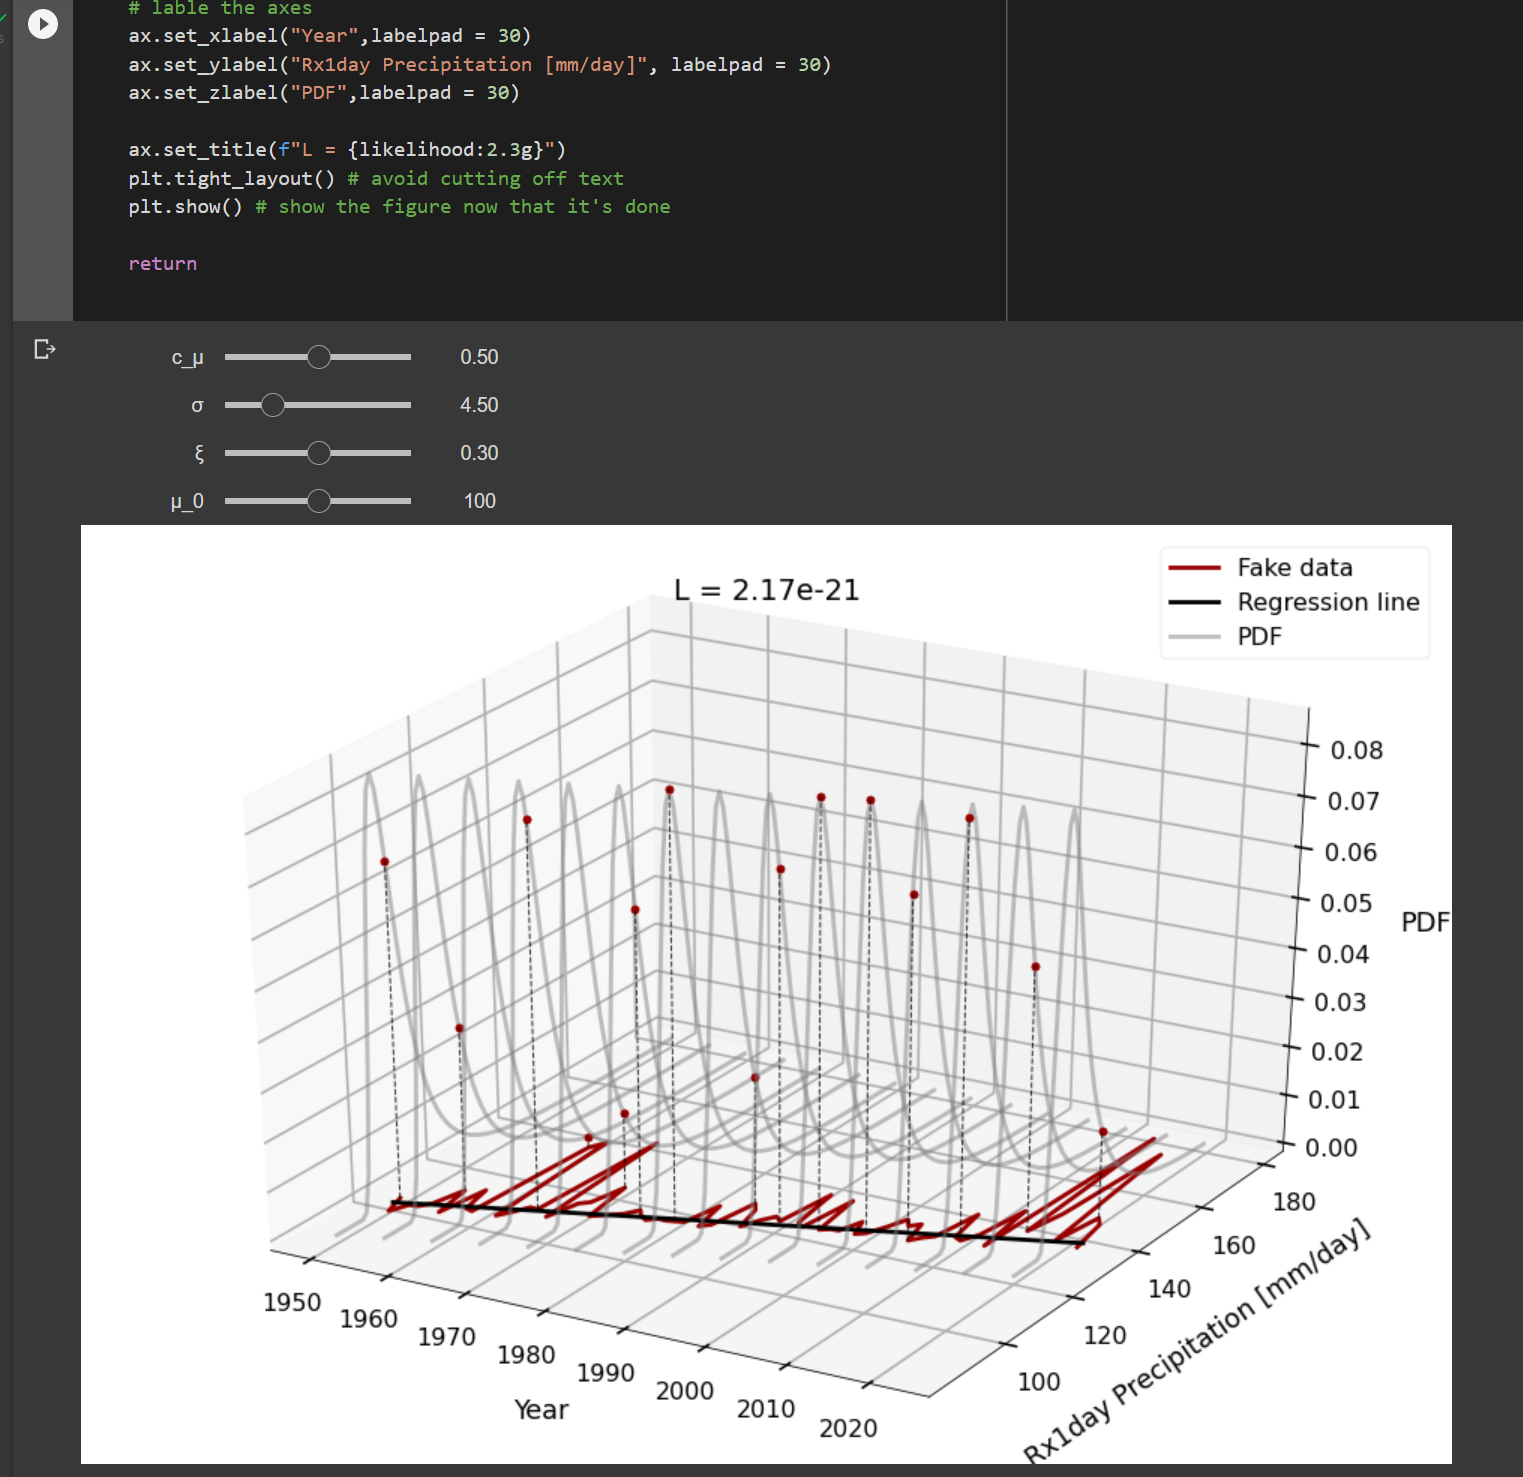 
 
## Part 2 - Maximize the likelihood

 1. Move the sliders around
 2. Try to slide them around until the likelihood L is maximzed (it's given in the plot title)
 3. Return to the worksheet
 
## Part 3 - Bootstrap

This part generates a 'bootstrap' sample by randomly selecting pairs of (year, precip) data points.  The goal here is to maximize the likelihood on the bootstrap sample; you'll likely get a slightly different result from above.

 1. Copy the code in cell 3 and paste it into your 3rd cell; run it (it should produce a plot like before)
 2. Again, try to maximize the likelihood by moving the sliders; record the result on your worksheet
 3. Re-run the same cell to generate a new bootstrap sample
 4. Maximize the likelihood again and record the result on your worksheet
 5. Repeat this several times

In [1]:
""" Import libraries """
import numpy as np # for numerical calculations
import matplotlib as mpl # for plotting
import matplotlib.pyplot as plt # also for plotting
import scipy.stats # for GEV and other distributions

# widgets for user-interaction
from ipywidgets import interact

# generate plots with user-modifiable controls
#%matplotlib widget

""" generate a fake Rx1day dataset for plotting """

# set the years (1950 to 2022)
years = np.arange(1950,2023)

# Set the nonstationary GEV parameters
c_μ = 0.5 # trend parameter (mm/day/year)
μ_0 = 100 # the starting value of the location parameter at year 1950 (mm/day)
σ = 3    # scale parameter (mm/day) 
ξ = 0.5   # shape parameter (unitless)

# initialize the precipitation dataset (one value per year)
precip_data = np.empty(len(years))

# set the state of the random number generator, for reproducibility
np.random.seed(238947)

# generate samples for each year
for n, year in enumerate(years):
    # calculate the location parameter for the current year
    μ = c_μ * (year - 1950) + μ_0
    
    # generate a single GEV sample for this year
    #  Note that the scipy genextremes packages uses the opposite sign convention for ξ
    #  to what we've used.
    data_point = scipy.stats.genextreme.rvs(loc = μ, scale = σ, c = -ξ, size = 1)
    
    # insert the data into the array
    precip_data[n] = data_point
    
print("If you're seeing this, the cell ran properly!  You can proceed to the next step.")

If you're seeing this, the cell ran properly!  You can proceed to the next step.


/tmp/ipykernel_67917/3318781811.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  precip_data[n] = data_point


In [2]:
@interact(μ_0 = (50, 150, 10), c_μ = (0,1,0.01), σ = (1,15,0.5), ξ = (0.1,0.5,0.01))
def plot_regression(c_μ, σ, ξ, μ_0):
    fig = plt.figure() # create the figure
    ax = plt.axes(projection = '3d') # create the single 3D subplot within the figure

    # plot the fake dataset in crimson
    z_fake = np.zeros(len(years))
    ax.plot(years, precip_data, z_fake, label = 'Fake data', color = "#990000")
    
    # plot a line representing the regression slope
    precip_regression = (years-1950)*c_μ + μ_0
    ax.plot(years, precip_regression, z_fake, color = 'k', label = 'Regression line')
    

    # set the label for the PDF plots
    label = "PDF"

    likelihood = 1
    # generate samples for every 5th year
    for year, data in zip(years[::5], precip_data[::5]):
        # calculate the location parameter for the current year
        μ = c_μ * (year - 1950) + μ_0

        # generate a PDF for the current year's μ
        rx1day_values = np.arange(μ - σ/ξ + 1e-8, 180)
        rx1day_pdf = scipy.stats.genextreme.pdf(rx1day_values, loc = μ, scale = σ, c = -ξ)

        # plot the PDF in 3D
        year_fake = year*np.ones(len(rx1day_values))
        ax.plot(year_fake, rx1day_values, rx1day_pdf, color = 'gray', alpha = 0.5, label = label)
        
        # also plot the PDF value of the actual data point in 3D
        if data > (μ - σ/ξ):
            data_likelihood = scipy.stats.genextreme.pdf(data, loc = μ, scale = σ, c = -ξ)
        else:
            data_likelihood = 0
        likelihood = likelihood * data_likelihood
        ax.plot(xs=[year,year], ys=[data, data], zs=[data_likelihood, data_likelihood], color = "#990000", linestyle = 'none', marker = '.')
        ax.plot([year,year], [data,data], [0,data_likelihood], color = "black", linestyle = '--', linewidth = 1, alpha = 0.8)

        # set the label to None to avoid labeling any but the first PDF plot
        if label is not None:
            label = None

    # add the legend
    ax.legend()

    # lable the axes
    ax.set_xlabel("Year",labelpad = 30)
    ax.set_ylabel("Rx1day Precipitation [mm/day]", labelpad = 30)
    ax.set_zlabel("PDF",labelpad = 30)
    
    ax.set_title(f"L = {likelihood:2.3g}")
    plt.tight_layout() # avoid cutting off text
    plt.show() # show the figure now that it's done
    
    return 

interactive(children=(FloatSlider(value=0.0, description='c_μ', max=1.0, step=0.01), FloatSlider(value=8.0, de…

In [3]:
""" Replot with a bootstrap sample """
# randomly select indices for the bootstrap permutation (re-running this regenerates the indices randomly)
i_bootstrap = np.random.choice(len(years), size = len(years), replace = True)
# sort the samples (not necessary but makes the plot look cleaner)
i_bootstrap = np.sort(i_bootstrap)

# extract bootstrap samples 
years_bootstrap = years[i_bootstrap]
precip_bootstrap = precip_data[i_bootstrap]


@interact(μ_0 = (50, 150, 10), c_μ = (0,1,0.01), σ = (1,15,0.5), ξ = (0.1,0.5,0.01))
def plot_regression(c_μ, σ, ξ, μ_0):
    fig = plt.figure() # create the figure
    ax = plt.axes(projection = '3d') # create the single 3D subplot within the figure

    # plot the bootstrap dataset in crimson
    z_fake = np.zeros(len(years))
    ax.plot(years_bootstrap, precip_bootstrap, z_fake, label = 'Fake data', color = "#990000")
    
    # plot a line representing the regression slope
    precip_regression = (years-1950)*c_μ + μ_0
    ax.plot(years, precip_regression, z_fake, color = 'k', label = 'Regression line')
    

    # set the label for the PDF plots
    label = "PDF"

    likelihood = 1
    # generate samples for every 5th year
    for year, data in zip(years[::5], precip_bootstrap[::5]):
        # calculate the location parameter for the current year
        μ = c_μ * (year - 1950) + μ_0

        # generate a PDF for the current year's μ
        rx1day_values = np.arange(μ - σ/ξ + 1e-8, 180)
        rx1day_pdf = scipy.stats.genextreme.pdf(rx1day_values, loc = μ, scale = σ, c = -ξ)

        # plot the PDF in 3D
        year_fake = year*np.ones(len(rx1day_values))
        ax.plot(year_fake, rx1day_values, rx1day_pdf, color = 'gray', alpha = 0.5, label = label)
        
        # also plot the PDF value of the actual data point in 3D
        if data > (μ - σ/ξ):
            data_likelihood = scipy.stats.genextreme.pdf(data, loc = μ, scale = σ, c = -ξ)
        else:
            data_likelihood = 0
        likelihood = likelihood * data_likelihood
        ax.plot(xs=[year,year], ys=[data, data], zs=[data_likelihood, data_likelihood], color = "#990000", linestyle = 'none', marker = '.')
        ax.plot([year,year], [data,data], [0,data_likelihood], color = "black", linestyle = '--', linewidth = 1, alpha = 0.8)

        # set the label to None to avoid labeling any but the first PDF plot
        if label is not None:
            label = None

    # add the legend
    ax.legend()

    # lable the axes
    ax.set_xlabel("Year",labelpad = 30)
    ax.set_ylabel("Rx1day Precipitation [mm/day]", labelpad = 30)
    ax.set_zlabel("PDF",labelpad = 30)
    
    ax.set_title(f"L = {likelihood:2.3g}")
    plt.tight_layout() # avoid cutting off text
    plt.show() # show the figure now that it's done
    
    return 

interactive(children=(FloatSlider(value=0.0, description='c_μ', max=1.0, step=0.01), FloatSlider(value=8.0, de…